In this file:

The goal is to perform a backtesting on the Prestige investment strategy

0) Getting the file    


1) Data Cleaning:    
    • Data ending by the end of 2020-06-01 (too many missing data in 2020);    
    • Removing the missing values 
    • Removing market cap lower than 50M


2) Computing the 2 metrics:   
    2.1 Earnings Yield --> EBIT / (Market Capital + Preferred Stock + Net Debt)    
    2.2 Return on Capital --> EBIT / (Working Capital + Net Fixed Assets)        
    2.3 Descriptive stats and removing outliers    
    
    • Remove firms with Earnings Yield higher than 0.2 (similar to excluding Price to Earnings smaller than 5, as indicated in the book, on page 97;    
    • Remove top 1%, according to initial descriptive stats
        
        
3) Ranking the stocks on both indicators, per day. Then, sum those rankings, and rank from smallest to largest (getting a final ranking)  


4) Get the list of the top 50 stocks per day    


5) Check for "bronze": create a dataframe of stocks, per day, which are new to the list over the past week (rolling window). Save the date. The index should be each date    


6) Backtest the strategy: Buying the 'bronze' stocks, and selling them after one week

Introducing a stop loss at -2%

Introducing a limit buy at +8%

In [1]:
import pandas as pd
import numpy as np

from dateutil.relativedelta import relativedelta

import ast

from matplotlib import pyplot as plt
from scipy import stats

### 0. Get the panel data file

In [2]:
df = pd.read_csv('./panel_data_extraction2.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #turning dates to datetime

In [4]:
pd.concat([df.head(3),df.tail(3)])

,Unnamed: 0,Date,Firm,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND
0,08/12/2000_IMGX.PK,2000-12-08,IMGX.PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/12/2000_IMGX.PK,2000-12-11,IMGX.PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12/12/2000_IMGX.PK,2000-12-12,IMGX.PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28647357,08/12/2020_BOXL.OQ,2020-12-08,BOXL.OQ,1.66,1.5600,1.52,1.68,84940.0,NaN,NaN,-647.47,NaN,NaN
28647358,09/12/2020_BOXL.OQ,2020-12-09,BOXL.OQ,1.66,1.7043,1.60,1.72,84940.0,NaN,NaN,-647.47,NaN,NaN
28647359,10/12/2020_BOXL.OQ,2020-12-10,BOXL.OQ,1.95,1.7500,1.71,1.98,99770.0,NaN,NaN,-647.47,NaN,NaN


In [80]:
len(df.Firm.unique())

5488

In [5]:
#How many rows and columns?
df.shape

(28647360, 13)

### 1. Data Cleaning

In [6]:
#First of all, I want to conserve the original dataframe, so that I don't lose stock prices along the way, so let's 
#create a new one:

df_new = df

#Excluding data from 2020
df_new = df_new.loc[df['Date'] < '2020-06-01']

#Removing missing data
df_new = df_new.dropna(subset = [*set(df.columns).difference(['PO','PL', 'PH'])])

#Removing market cap lower than 50M
df_new = df_new.loc[df['MC'] > 50000]

#Checking values left
df_new.shape

(8040035, 13)

In [7]:
df['Unnamed: 0'] = df['Date'].astype(str) + df['Firm']

### 2. Computing the 2 metrics

##### 2.0 Initial Descriptive stats

In [8]:
df_new.describe().apply(round)

,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND
count,8.040035e+06,7.607128e+06,7.605615e+06,7.584365e+06,8.040035e+06,8040035.0,8040035.0,8040035.0,8.040035e+06,8040035.0
mean,1.338540e+08,1.276075e+08,1.188973e+08,1.327753e+08,7.388183e+06,532204.0,620132.0,2154894.0,1.231233e+07,1129972.0
std,2.152164e+10,1.845724e+10,1.742898e+10,1.934880e+10,3.561099e+07,2662258.0,4508029.0,8720988.0,1.703024e+08,8991766.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.001000e+04,-48033955.0,-165338000.0,-128979100.0,-4.900000e+07,-160870190.0
25%,1.000000e+01,1.100000e+01,1.000000e+01,1.100000e+01,2.190300e+05,-2942.0,23817.0,79301.0,0.000000e+00,-46545.0
50%,2.200000e+01,2.200000e+01,2.200000e+01,2.300000e+01,8.091200e+05,44142.0,116863.0,303496.0,0.000000e+00,18722.0
75%,4.400000e+01,4.400000e+01,4.400000e+01,4.500000e+01,3.263260e+06,248861.0,408700.0,1136556.0,0.000000e+00,529200.0
max,2.730000e+13,2.550000e+13,2.400000e+13,2.730000e+13,4.142027e+09,76143000.0,290102000.0,194984700.0,1.190300e+10,475575000.0


##### 2.1 Earnings Yield   
EBIT / (Market Capital + Preferred Stock + Net Debt)

In [9]:
df_new.loc[:, 'MC+PS+ND'] = df_new['MC'] + df_new['PS'] + df_new['ND']
df_new.loc[:, 'EY'] = df_new['EBIT']/df_new['MC+PS+ND']

##### 2.2 Return on Capital (RoC)

EBIT / (Working Capital + Net Fixed Assets)   

In [10]:
df_new.loc[:,'WC+NFA'] = df_new['WC'] + df_new['NFA']
df_new.loc[:,'RoC'] = df_new['EBIT'] / df_new['WC+NFA']

##### 2.3 Descriptive stats of the metrics

In [11]:
#reordering the columns:
df_new = df_new[['Unnamed: 0', 'Date', 'Firm', 'PC', 'PO', 'PL','PH', 'MC', 'EBIT', 'WC',
       'NFA', 'PS', 'ND', 'MC+PS+ND', 'WC+NFA', 'EY', 'RoC']]

In [12]:
df_new.describe().round(1)

,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND,MC+PS+ND,WC+NFA,EY,RoC
count,8.040035e+06,7.607128e+06,7.605615e+06,7.584365e+06,8.040035e+06,8040035.0,8040035.0,8040035.0,8.040035e+06,8040035.0,8.040035e+06,8040035.0,8040035.0,8039886.0
mean,1.338540e+08,1.276075e+08,1.188973e+08,1.327753e+08,7.388183e+06,532204.1,620132.1,2154894.1,1.231233e+07,1129971.8,2.083048e+07,2775026.2,0.0,-inf
std,2.152164e+10,1.845724e+10,1.742898e+10,1.934880e+10,3.561099e+07,2662257.6,4508029.1,8720988.3,1.703024e+08,8991765.6,1.768261e+08,10985910.6,23.5,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.001000e+04,-48033955.0,-165338000.0,-128979100.0,-4.900000e+07,-160870190.0,-1.796880e+06,-128882171.0,-16720.0,-inf
25%,1.040000e+01,1.060000e+01,1.040000e+01,1.090000e+01,2.190300e+05,-2942.0,23817.0,79301.0,0.000000e+00,-46545.0,2.494055e+05,130582.0,-0.0,-0.0
50%,2.200000e+01,2.220000e+01,2.180000e+01,2.270000e+01,8.091200e+05,44142.0,116863.0,303496.0,0.000000e+00,18722.0,1.115960e+06,467551.0,0.1,0.1
75%,4.430000e+01,4.440000e+01,4.370000e+01,4.510000e+01,3.263260e+06,248861.0,408700.0,1136556.0,0.000000e+00,529200.0,5.191385e+06,1606929.0,0.1,0.2
max,2.730000e+13,2.550000e+13,2.400000e+13,2.730000e+13,4.142027e+09,76143000.0,290102000.0,194984700.0,1.190300e+10,475575000.0,1.194564e+10,420668000.0,37818.3,1158.3


In [13]:
#Removing any observations with MC+PS+ND with a negative value:
df_new = df_new.loc[df_new['MC+PS+ND']>= 0]

In [14]:
print('The 97th percentile in RoC is: {}'.format(df_new.RoC.quantile(0.97)))

The 97th percentile in RoC is: 1.1216617210682494


In [15]:
#Removing the top 3% of RoC
df_new = df_new.loc[df_new['RoC'] < 1.0775203149706591]

#Removing the minus infinity in RoC:
df_new = df_new.loc[df_new['RoC'] != df_new['RoC'].min()]

In [16]:
# Removing all the Earning Yield values higher than 0.2:

print('This removes {} rows, which represents {}% of the data'.format(len(df_new) - len(df_new.loc[df_new['EY']<0.2]), (len(df_new) - len(df_new.loc[df_new['EY']<0.2]))/len(df_new)*100))
df_new = df_new.loc[df_new['EY']<0.2]

This removes 239294 rows, which represents 3.0881319198376738% of the data


In [17]:
#Final descriptive stats:
df_new.describe().round(1)

,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND,MC+PS+ND,WC+NFA,EY,RoC
count,7.509533e+06,7.120690e+06,7.119594e+06,7.099988e+06,7.509533e+06,7509533.0,7509533.0,7509533.0,7.509533e+06,7509533.0,7.509533e+06,7509533.0,7509533.0,7509533.0
mean,1.422561e+08,1.352481e+08,1.269629e+08,1.407005e+08,7.548542e+06,527568.7,648838.5,2240932.8,1.272472e+07,1139923.4,2.141318e+07,2889771.3,-0.0,-0.3
std,2.226824e+10,1.907651e+10,1.801403e+10,1.999712e+10,3.649116e+07,2663113.2,4625126.9,8919300.5,1.747921e+08,9190188.5,1.814802e+08,11249040.5,10.8,20.1
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.001000e+04,-48033955.0,-165338000.0,-128979100.0,-4.900000e+07,-160870190.0,4.000000e+00,-128882171.0,-16720.0,-5231.9
25%,1.070000e+01,1.090000e+01,1.070000e+01,1.120000e+01,2.337800e+05,-3071.0,26275.0,86103.0,0.000000e+00,-45187.0,2.709560e+05,139144.7,-0.0,-0.0
50%,2.230000e+01,2.250000e+01,2.210000e+01,2.300000e+01,8.617100e+05,43438.0,122204.0,325248.0,0.000000e+00,23054.0,1.180617e+06,498792.0,0.1,0.1
75%,4.450000e+01,4.460000e+01,4.380000e+01,4.530000e+01,3.352610e+06,243086.0,422600.0,1185922.0,0.000000e+00,540043.0,5.286114e+06,1690800.0,0.1,0.2
max,2.730000e+13,2.550000e+13,2.400000e+13,2.730000e+13,4.142027e+09,76143000.0,290102000.0,194984700.0,1.190300e+10,475575000.0,1.194564e+10,420668000.0,0.2,1.1


### 3. Rank the top performing stocks, per day

In [18]:
#Sort the dataframe by date, then by firm
df_new = df_new.sort_values(by = ['Date', 'Firm']).reset_index(drop = True)

In [84]:
df_new.Date.sort_values()

0         2000-12-08
574       2000-12-08
575       2000-12-08
576       2000-12-08
577       2000-12-08
             ...    
7509342   2020-05-29
7509341   2020-05-29
7509340   2020-05-29
7509346   2020-05-29
7509532   2020-05-29
Name: Date, Length: 7509533, dtype: datetime64[ns]

In [19]:
pd.concat([df_new.head(), df_new.tail()])

,Unnamed: 0,Date,Firm,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND,MC+PS+ND,WC+NFA,EY,RoC
0,08/12/2000_A.N,2000-12-08,A.N,40.0472,37.9838,37.8154,40.3420,26926070.0,-477000.0,2797000.0,5659000.00,0.0,-1164000.0,25762070.0,8456000.00,-0.018516,-0.056410
1,08/12/2000_AAON.OQ,2000-12-08,AAON.OQ,1.9643,1.9643,1.9643,1.9753,130090.0,21263.0,15456.0,37012.00,0.0,13696.0,143786.0,52468.00,0.147879,0.405257
2,08/12/2000_AAPL.OQ,2000-12-08,AAPL.OQ,0.2690,0.2645,0.2578,0.2734,4902660.0,-36000.0,3625000.0,3920000.00,0.0,-4019000.0,883660.0,7545000.00,-0.040740,-0.004771
3,08/12/2000_ABC.N,2000-12-08,ABC.N,10.3719,10.0687,10.0687,10.5236,2188930.0,259376.0,1980049.0,2838564.00,274616000.0,1302137.0,278107067.0,4818613.00,0.000933,0.053828
4,08/12/2000_ABEO.OQ,2000-12-08,ABEO.OQ,1437.5000,1312.5000,1281.2500,1453.1250,69520.0,-5086.0,24397.0,16049.00,0.0,-12279.0,57241.0,40446.00,-0.088852,-0.125748
7509528,29/05/2020_WNDW.PK,2020-05-29,WNDW.PK,3.0500,2.9100,2.7700,3.2800,161530.0,-7353.0,14591.0,15967.13,0.0,-14152.0,147378.0,30558.13,-0.049892,-0.240623
7509529,29/05/2020_WOR.N,2020-05-29,WOR.N,29.9200,29.4700,28.8550,30.0100,1661970.0,27615.0,594941.0,820821.00,0.0,552467.0,2214437.0,1415762.00,0.012470,0.019505
7509530,29/05/2020_WRK.N,2020-05-29,WRK.N,28.0600,28.5000,27.5800,28.7300,7274700.0,-72900.0,2015800.0,10630600.00,0.0,9179500.0,16454200.0,12646400.00,-0.004430,-0.005764
7509531,29/05/2020_WWD.OQ,2020-05-29,WWD.OQ,68.5800,67.4700,66.8800,69.7100,4271820.0,302112.0,818533.0,1992677.00,0.0,685213.0,4957033.0,2811210.00,0.060946,0.107467
7509532,29/05/2020_ZS.OQ,2020-05-29,ZS.OQ,98.0900,87.0800,85.5000,98.3800,12802540.0,-107703.0,1157892.0,484829.00,0.0,-507501.0,12295039.0,1642721.00,-0.008760,-0.065564


In [20]:
#Ranking the RoC per date:
df_new['Rank_RoC'] = df_new.groupby('Date')['RoC'].rank(ascending = False)

#Ranking the EY per date:
df_new['Rank_EY'] = df_new.groupby('Date')['EY'].rank(ascending = False)

In [21]:
df_new.head(10)

,Unnamed: 0,Date,Firm,PC,PO,PL,PH,MC,EBIT,WC,NFA,PS,ND,MC+PS+ND,WC+NFA,EY,RoC,Rank_RoC,Rank_EY
0,08/12/2000_A.N,2000-12-08,A.N,40.0472,37.9838,37.8154,40.3420,26926070.0,-477000.0,2797000.0,5659000.0,0.0,-1164000.0,25762070.0,8456000.0,-0.018516,-0.056410,708.0,739.0
1,08/12/2000_AAON.OQ,2000-12-08,AAON.OQ,1.9643,1.9643,1.9643,1.9753,130090.0,21263.0,15456.0,37012.0,0.0,13696.0,143786.0,52468.0,0.147879,0.405257,74.0,85.0
2,08/12/2000_AAPL.OQ,2000-12-08,AAPL.OQ,0.2690,0.2645,0.2578,0.2734,4902660.0,-36000.0,3625000.0,3920000.0,0.0,-4019000.0,883660.0,7545000.0,-0.040740,-0.004771,670.0,766.0
3,08/12/2000_ABC.N,2000-12-08,ABC.N,10.3719,10.0687,10.0687,10.5236,2188930.0,259376.0,1980049.0,2838564.0,274616000.0,1302137.0,278107067.0,4818613.0,0.000933,0.053828,617.0,658.0
4,08/12/2000_ABEO.OQ,2000-12-08,ABEO.OQ,1437.5000,1312.5000,1281.2500,1453.1250,69520.0,-5086.0,24397.0,16049.0,0.0,-12279.0,57241.0,40446.0,-0.088852,-0.125748,749.0,806.0
5,08/12/2000_ABM.N,2000-12-08,ABM.N,15.1875,14.8750,14.8750,15.1875,693250.0,55547.0,229542.0,361177.0,0.0,8767.0,702017.0,590719.0,0.079125,0.094033,541.0,338.0
6,08/12/2000_ABT.N,2000-12-08,ABT.N,22.2349,22.8503,21.9552,22.8503,76854750.0,3449005.0,3078701.0,8570906.0,0.0,399104.0,77253854.0,11649607.0,0.044645,0.296062,154.0,485.0
7,08/12/2000_ACIW.OQ,2000-12-08,ACIW.OQ,5.2708,5.1042,5.0833,5.3333,523390.0,-42807.0,63355.0,218668.0,0.0,-21582.0,501808.0,282023.0,-0.085306,-0.151785,759.0,803.0
8,08/12/2000_ACLS.OQ,2000-12-08,ACLS.OQ,33.3750,29.2500,28.7500,33.3750,796830.0,124702.0,297348.0,491369.0,0.0,-168157.0,628673.0,788717.0,0.198357,0.158107,395.0,2.0
9,08/12/2000_ADBE.OQ,2000-12-08,ADBE.OQ,34.1875,33.3437,33.0312,35.9687,16373070.0,306931.0,453713.0,616972.0,0.0,-581613.0,15791457.0,1070685.0,0.019437,0.286668,164.0,579.0


In [22]:
#Create a column to sum the rankings:
df_new['Final_Rating'] = df_new['Rank_RoC'] + df_new['Rank_EY']

#Turn the final rating to a final ranking:
df_new['Final_Ranking'] = df_new.groupby('Date')['Final_Rating'].rank()

### 4. Get the top 50 best stocks, per day

In [23]:
#First, sort the values by date, then by final ranking
df_new = df_new.sort_values(['Date','Final_Ranking']).reset_index(drop = True)

In [24]:
#Create a dataframe including the top 50 firms per date only
top50 = df_new.groupby('Date')['Date', 'Firm','PO','RoC', 'EY','Final_Ranking'].head(50)

C:\Users\jlbgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [25]:
#Now, a dataframe with one row per date, with the list of top 50 firms of the day:
top_50_daily = pd.DataFrame(index = df_new['Date'].unique(), columns = ['top_50', 'top_50_trailing_week'])

#inserting top 50 per day:
for date in top_50_daily.index:
    top_50_daily.loc[date, 'top_50'] = [*top50.loc[top50['Date'] == date, 'Firm']]
    
#inserting the list of firms that were top 50 during the week (rolling winsow):
for date in top_50_daily.index[5:]:
    top_week = top_50_daily.loc[date + relativedelta(days = -7): date + relativedelta(days = -1), 'top_50']
    #get the list of the trailing week, with no duplicates:
    top_50_daily.loc[date, 'top_50_trailing_week'] = [*set([*top_week.apply(pd.Series).stack().reset_index()[0]])]

### 5. Check for bronze: are there any new stocks on the week (trailing)?

In [26]:
top_50_daily.head(7)

,top_50,top_50_trailing_week
2000-12-08,"[YRCW.OQ, TUESQ.PK, HRB.N, WHR.N, BYD.N, MGRC....",NaN
2000-12-11,"[YRCW.OQ, TUESQ.PK, HRB.N, WHR.N, BYD.N, MGRC....",NaN
2000-12-12,"[YRCW.OQ, TUESQ.PK, HRB.N, USPH.N, WHR.N, BYD....",NaN
2000-12-13,"[YRCW.OQ, TUESQ.PK, HRB.N, WHR.N, USPH.N, BYD....",NaN
2000-12-14,"[HRB.N, TUESQ.PK, USPH.N, WHR.N, BYD.N, PKG.N,...",NaN
2000-12-15,"[TUESQ.PK, HRB.N, WHR.N, USPH.N, PKG.N, BYD.N,...","[HXL.N, FCN.N, RRD.N, AME.N, DVN.N, ITT.N, ADT..."
2000-12-18,"[TUESQ.PK, HRB.N, WHR.N, BYD.N, ROST.OQ, PKG.N...","[HXL.N, FCN.N, RRD.N, AME.N, DVN.N, ITT.N, DFO..."


In [29]:
top_50_daily['bronze'] = np.nan

for date in top_50_daily.index[5:]:
    top_50_daily.loc[date, 'bronze'] = str([*set(top_50_daily.loc[date, 'top_50']).difference(top_50_daily.loc[date, 'top_50_trailing_week'])])

#turning string to list on the 'bronze' column:
top_50_daily.loc['2000-12-15':, 'bronze'] = top_50_daily.loc['2000-12-15':,'bronze'].apply(ast.literal_eval)

#for whatever reason, the first element was not inserted as a list, so let's do it manually:
#top_50_daily.iloc[5, 2] = [*set(top_50_daily.iloc[5, 0]).difference(top_50_daily.iloc[5, 1])]

### 6. Backtesting the Prestige Bronze Strategy

#### How frequently 'bronze' stocks appear, on a daily basis?

<AxesSubplot:>

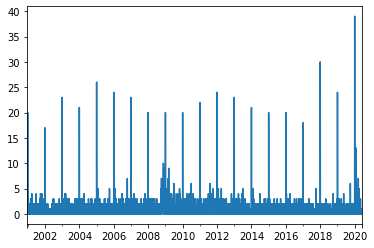

In [30]:
top_50_daily.loc['2000-12-15':,'bronze'].apply(len).plot()

In [31]:
top_50_daily.loc['2000-12-15':,'bronze'].apply(len).describe()

count    5076.000000
mean        0.915682
std         1.707354
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        39.000000
Name: bronze, dtype: float64

In [32]:
top_50_daily.loc['2000-12-15':,'bronze'].apply(len).nlargest(20)

2020-01-01    39
2018-01-01    30
2005-01-03    26
2006-01-02    24
2012-01-02    24
2019-01-01    24
2003-01-01    23
2007-01-01    23
2013-01-01    23
2011-01-03    22
2004-01-01    21
2014-01-01    21
2001-01-01    20
2008-01-01    20
2009-01-01    20
2010-01-01    20
2015-01-01    20
2016-01-01    20
2017-01-02    18
2002-01-01    17
Name: bronze, dtype: int64

__A first obvious remark__: on the first trading day of each year, there are several new stocks appearing. I do not want to include these for the backtesting, so I'll remove them.

In [33]:
#Removing the 20 largest days (all represent the beggining of the year)
top_50_daily = top_50_daily.loc[top_50_daily.index.isin(top_50_daily.loc['2000-12-15':,'bronze'].apply(len).nlargest(20).index) == False]

<AxesSubplot:>

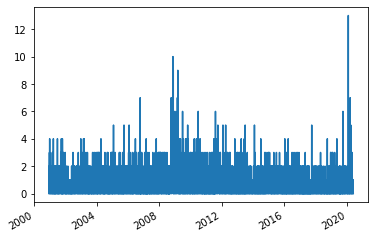

In [34]:
#plotting again
top_50_daily.loc['2000-12-15':,'bronze'].apply(len).plot()

In [35]:
daily_frequency = top_50_daily.loc['2000-12-15':,'bronze'].reset_index()['bronze'].apply(len).value_counts().sort_index()
daily_frequency.to_excel("./daily_frequency.xlsx")
daily_frequency

0     2169
1     1982
2      661
3      160
4       50
5       18
6        7
7        4
8        1
9        2
10       1
13       1
Name: bronze, dtype: int64

In [101]:
help(top_50_daily.loc['2000-12-15':,'bronze'].reset_index()['bronze'].apply(len).value_counts().sort_index().plot)

Help on PlotAccessor in module pandas.plotting._core object:

class PlotAccessor(pandas.core.base.PandasObject)
 |  PlotAccessor(data)
 |  
 |  Make plots of Series or DataFrame.
 |  
 |  Uses the backend specified by the
 |  option ``plotting.backend``. By default, matplotlib is used.
 |  
 |  Parameters
 |  ----------
 |  data : Series or DataFrame
 |      The object for which the method is called.
 |  x : label or position, default None
 |      Only used if data is a DataFrame.
 |  y : label, position or list of label, positions, default None
 |      Allows plotting of one column versus another. Only used if data is a
 |      DataFrame.
 |  kind : str
 |      The kind of plot to produce:
 |  
 |      - 'line' : line plot (default)
 |      - 'bar' : vertical bar plot
 |      - 'barh' : horizontal bar plot
 |      - 'hist' : histogram
 |      - 'box' : boxplot
 |      - 'kde' : Kernel Density Estimation plot
 |      - 'density' : same as 'kde'
 |      - 'area' : area plot
 |      - 'p

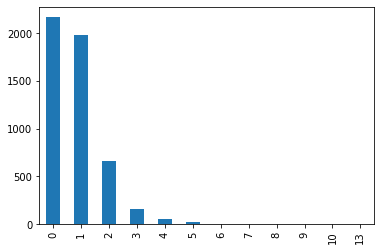

In [108]:
top_50_daily.loc['2000-12-15':,'bronze'].reset_index()['bronze'].apply(len).value_counts().sort_index().plot.bar()
plt.savefig("./daily_frequency_stocks.png", dpi=700, transparent=True)

In [37]:
top_50_daily.loc['2000-12-15':,'bronze'].apply(len).describe()

count    5056.000000
mean        0.829312
std         0.972591
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        13.000000
Name: bronze, dtype: float64

In [38]:
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).describe()

count    1166.000000
mean        0.643225
std         0.875798
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        13.000000
Name: bronze, dtype: float64

#### Getting the daily returns of the stocks we are long on - we keep them for one week

The code below takes a great amount of time to run. Instead, import the prestige_backtesting.csv file, with the output

In [39]:
#Let's create panel data dataframe called 'returns', including only the stocks that are bronze,
# solely on the respective dates we go long on them

returns = pd.DataFrame(columns = ['Date','Firm'])

dates = []
firms = []

for day in top_50_daily.index[4:len(top_50_daily)-5]:
    if type(top_50_daily.loc[day,'bronze']) == list and len(top_50_daily.loc[day,'bronze']) > 0:
        for firm in top_50_daily.loc[day,'bronze']:
            if day.weekday() == 0:
                dates = dates + [day + relativedelta(days =+i) for i in range(5)] + [day + relativedelta(days =+i) for i in range(7,9)]
            elif day.weekday() == 1:
                dates = dates + [day + relativedelta(days =+i) for i in range(4)] + [day + relativedelta(days =+i) for i in range(6,9)]
            elif day.weekday() == 2:
                dates = dates + [day + relativedelta(days =+i) for i in range(3)] + [day + relativedelta(days =+i) for i in range(5,9)]
            elif day.weekday() == 3:
                dates = dates + [day + relativedelta(days =+i) for i in range(2)] + [day + relativedelta(days =+i) for i in range(4,9)]
            elif day.weekday() == 4:
                dates = dates + [day] + [day + relativedelta(days =+i) for i in range(3,8)] + [day + relativedelta(days = +10)]
            
            firms = firms + [firm]*7
            
returns['Date'] = dates
returns['Firm'] = firms

In [40]:
#Creating a new column for a trade identifier
returns['Trade_Identifier'] = np.nan

#inserting the trade dentifiers:
for firm in returns['Firm'].unique():
    y = 1
    trade_identifier = []
    for i, x in enumerate([*returns.loc[returns['Firm'] == firm, 'Firm']]):
        if i != 0 and (i)%7 == 0:
            y = y+1
        trade_identifier.append(x+str(y))
    returns.loc[returns['Firm'] == firm, 'Trade_Identifier'] = trade_identifier

In [41]:
#Creating a key:
returns['key'] = returns['Date'].astype(str) + returns['Firm']

#Setting key as the index:
returns = returns.set_index('key')
df.set_index('Unnamed: 0', inplace = True)

#merging the datasets, so that we include the prices on the returns dataframe:
returns = returns.merge(df[['PC','PO', 'PL', 'PH']], left_on = returns.index, right_on = df.index)

#Setting date as the index:
returns.set_index('Date', inplace = True)


#inserting the top_50 and bronze stocks
returns = returns.merge(top_50_daily[['top_50','bronze']], left_index = True, right_index = True, how = 'left')

#Removing the extra days I added on returns (includes weekends and holidays)
returns = returns.dropna(subset = ['Firm','Trade_Identifier','top_50','bronze','PC'])

In [42]:
#Inserting the returns:
#PC:
returns['daily_return'] = returns.groupby('Trade_Identifier')['PC'].pct_change()

#PO:
returns['daily_return_PO'] = returns.groupby('Trade_Identifier')['PO'].pct_change()

## Results: original strategy

In [43]:
#First, only the returns from the second day counts: 
# •first day - bronze identified
# •second day - buy stock at close price
#So, we need to remove the first 2 days:
returns = returns.rename_axis('Date').sort_values(['Firm','Date'])
returns = returns.reset_index()
returns = returns.set_index('key_0')

returns['returns_prestige_original'] = returns['daily_return']

#replacing the first two values with nan
returns.loc[returns.groupby('Trade_Identifier').head(1).index, 'returns_prestige_original'] = np.nan

#replacing the last value with nan
returns.loc[returns.groupby('Trade_Identifier').tail(1).index, 'returns_prestige_original'] = np.nan

#sorting and replacing index again:
returns = returns.reset_index()
returns = returns.set_index('Date')

returns = returns.sort_values(['Date', 'Firm'])

#### Cumulative sum of returns

<AxesSubplot:xlabel='Date'>

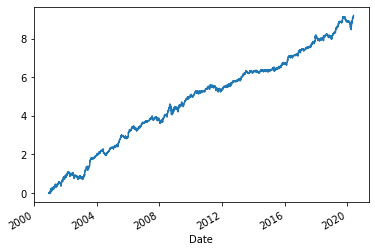

In [44]:
returns.groupby(returns.index)['returns_prestige_original'].mean().cumsum().plot()

#### Cumulative Product of returns

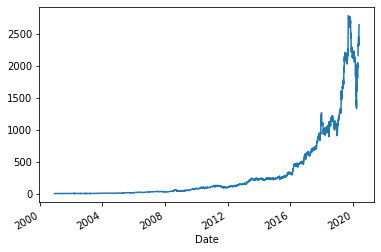

In [92]:
(returns.groupby(returns.index)['returns_prestige_original'].mean() +1).cumprod().plot()
plt.savefig("./backtesting20y.png", dpi=700, transparent=True)

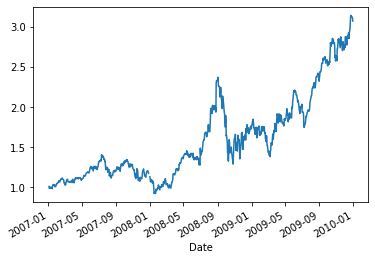

In [93]:
(returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['returns_prestige_original'].mean() +1).cumprod().plot()
plt.savefig("./backtesting07-09.png", dpi=700, transparent=True)

In [47]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['returns_prestige_original'].mean().mean()*252*100
stdev = returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['returns_prestige_original'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 46.25%
Average yearly standard deviation: 44.97%
Sharpe Ratio: 1.0173020666740322


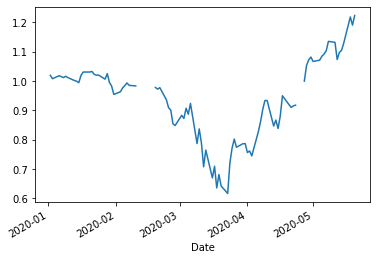

In [94]:
(returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['returns_prestige_original'].mean() +1).cumprod().plot()
plt.savefig("./backtesting2020.png", dpi=700, transparent=True)

In [49]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['returns_prestige_original'].mean().mean()*252*100
stdev = returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['returns_prestige_original'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 82.21%
Average yearly standard deviation: 74.25%
Sharpe Ratio: 1.1005835282931151


#### Descriptive statistics of the investment strategy

Descriptive statistics

In [50]:
returns.groupby(returns.index)['returns_prestige_original'].mean().describe()

count    4979.000000
mean        0.001847
std         0.023058
min        -0.176664
25%        -0.008675
50%         0.000864
75%         0.011552
max         0.264335
Name: returns_prestige_original, dtype: float64

In [51]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.groupby(returns.index)['returns_prestige_original'].mean().mean()*252*100
stdev = returns.groupby(returns.index)['returns_prestige_original'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 46.54%
Average yearly standard deviation: 36.6%
Sharpe Ratio: 1.2577398858556412


5 Worst performing stocks

### Creating a weekly returns dataframe

In [52]:
weekly_returns = pd.DataFrame({'Trade_Identifier': returns['Trade_Identifier'].unique()}) #insert trade ids
weekly_returns['Date'] = [*returns.reset_index().groupby('Trade_Identifier')['Date'].tail(1)] #insert dates
weekly_returns.set_index('Trade_Identifier', inplace = True)

#getting the weekly returns for the original prestige strategy
weekly_returns['returns_prestige_original'] = returns.groupby('Trade_Identifier')['PC'].nth(-1)/returns.groupby('Trade_Identifier')['PC'].nth(0)-1

Distribution

In [53]:
#create a function for a histogram with weekly returns
def histogram(df):
    fig, ax = plt.subplots()
    plt.hist(df, bins=100, density=True, alpha=0.6, color="darkgoldenrod", edgecolor = "k")
    ## Consistent with np.histogram.

    csfont = {'fontname':'Times New Roman','size': 11.5} #setting font to Times New Roman, size 10


    # Normal curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 50)
    p = stats.norm.pdf(x,
                       df.mean(),
                       df.std())
    plt.plot(x, p, 'k', linewidth=2)

    # Other definitions
    plt.xlabel('{} '.format("Weekly Returns"), **csfont)
    plt.ylabel('DENSITY', **csfont)
    plt.annotate('Normal distribution', xy=(0.1,2.4), **csfont)
    plt.tight_layout()

    ax.tick_params(axis='both', which='major', labelsize=7.8)
    ax.tick_params(axis='both', which='minor', labelsize=7.8)

    ax.spines["top"].set_color("w")
    ax.spines["right"].set_color("w")

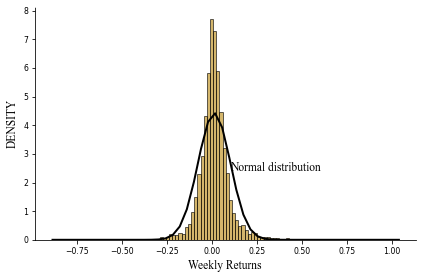

In [95]:
histogram(weekly_returns['returns_prestige_original'])
plt.savefig("./backtesting20y_hist.png", dpi=700, transparent=True)

In [55]:
weekly_returns.describe()

,returns_prestige_original
count,4192.000000
mean,0.011563
std,0.090218
min,-0.800000
25%,-0.029999
50%,0.007079
75%,0.046439
max,0.951107


## Adjusting the original strategy: Including a stop loss order
If, we reach a negative return of -2%, we drop the position   
Note: The prices low (PL) have more missing values than do close prices. I will be removing such trades with missing values on PL

In [56]:
#setting the maximum loss of the day
returns['max_loss'] = returns['PL'].div(returns.groupby('Trade_Identifier')['PC'].transform('first'))-1

#setting the index to the key:
returns.reset_index(inplace = True)
returns.set_index('key_0', inplace = True)

#replacing the first value with nan
returns.loc[returns.groupby('Trade_Identifier').head(1).index, 'max_loss'] = np.nan

#creating a column for the returns using the strategy with the stoploss:
returns['daily_return_stoploss'] = returns['returns_prestige_original']

#list od trade ids which had a max loss of at least -2%:
stop_loss_list = [*returns.loc[returns['max_loss']<= -0.02, 'Trade_Identifier'].unique()]

#for the trades that the stoploss was reached, first replace all the returns with 0%:
returns.loc[returns['Trade_Identifier'].isin(stop_loss_list), 'daily_return_stoploss'] = 0
#then, replace the last value with -2%:
returns.loc[returns.loc[returns['Trade_Identifier'].isin(stop_loss_list)].groupby('Trade_Identifier').tail(1).index, 'daily_return_stoploss'] = -0.02

#setting the index again back to date:
returns.reset_index(inplace = True)
returns.set_index('Date', inplace = True)

In [57]:
#identifying the trades that had at one point in time a loss of 2%
print("Total number of trades: {}".format(len(returns['Trade_Identifier'].unique())))
print("Number of trades that reach the stoploss: {}".format(len(returns.loc[returns['max_loss'] <= -0.02, 'Trade_Identifier'].unique())))
print("Proportion of stop loss to total trades: {}%".format((len(returns.loc[returns['max_loss'] <= -0.02, 'Trade_Identifier'].unique())/len(returns['Trade_Identifier'].unique()))*100))

Total number of trades: 4192
Number of trades that reach the stoploss: 2713
Proportion of stop loss to total trades: 64.71851145038168%


In [58]:
returns.loc[returns['Trade_Identifier'].isin(stop_loss_list), 'returns_prestige_original'].describe()

count    13521.000000
mean        -0.002116
std          0.047269
min         -0.700000
25%         -0.018222
50%         -0.001965
75%          0.012349
max          2.166667
Name: returns_prestige_original, dtype: float64

In [59]:
returns.loc[returns['Trade_Identifier'].isin(stop_loss_list) == False, 'returns_prestige_original'].describe()

count    7356.000000
mean        0.010222
std         0.031133
min        -0.290229
25%        -0.002678
50%         0.005326
75%         0.018477
max         0.733333
Name: returns_prestige_original, dtype: float64

### Cumultive product of returns: stop loss strategy

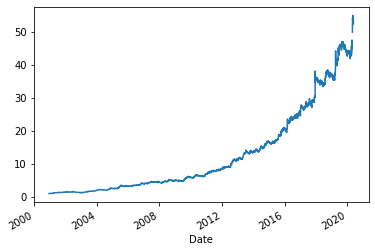

In [96]:
(returns.groupby(returns.index)['daily_return_stoploss'].mean() +1).cumprod().plot()
plt.savefig("./backtesting20y_stoploss.png", dpi=700, transparent=True)

In [61]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.groupby(returns.index)['daily_return_stoploss'].mean().mean()*252*100
stdev = returns.groupby(returns.index)['daily_return_stoploss'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 20.89%
Average yearly standard deviation: 14.3%
Sharpe Ratio: 1.4258401997226506


In [62]:
#getting the weekly returns for the stop loss strategy at -2%
weekly_returns['returns_stoploss'] = returns.groupby('Trade_Identifier')['PC'].nth(-1)/returns.groupby('Trade_Identifier')['PC'].nth(0)-1
weekly_returns.loc[stop_loss_list, 'returns_stoploss'] = -0.02

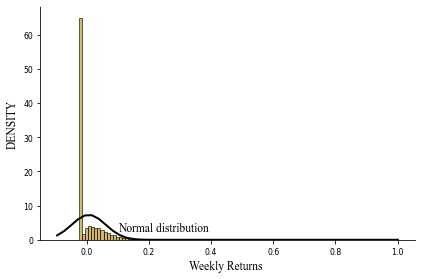

In [97]:
histogram(weekly_returns['returns_stoploss'])
plt.savefig("./backtesting20y_hist_stoploss.png", dpi=700, transparent=True)

In [64]:
weekly_returns['returns_stoploss'].describe()

count    4192.000000
mean        0.006175
std         0.054537
min        -0.045711
25%        -0.020000
50%        -0.020000
75%         0.017362
max         0.951107
Name: returns_stoploss, dtype: float64

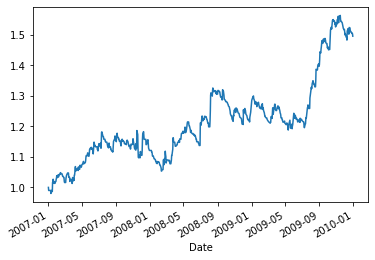

In [98]:
(returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['daily_return_stoploss'].mean() +1).cumprod().plot()
plt.savefig("./backtesting07-09_stoploss.png", dpi=700, transparent=True)

In [66]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['daily_return_stoploss'].mean().mean()*252*100
stdev = returns.loc['2007-01-01':'2009-12-31'].groupby(returns.loc['2007-01-01':'2009-12-31'].index)['daily_return_stoploss'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 13.8%
Average yearly standard deviation: 12.92%
Sharpe Ratio: 1.029470868445131


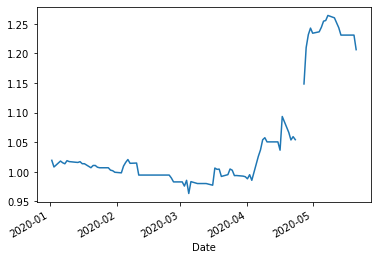

In [99]:
(returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['daily_return_stoploss'].mean() +1).cumprod().plot()
plt.savefig("./backtesting2020_stoploss.png", dpi=700, transparent=True)

In [68]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['daily_return_stoploss'].mean().mean()*252*100
stdev = returns.loc['2020-01-01':].groupby(returns.loc['2020-01-01':].index)['daily_return_stoploss'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 52.08%
Average yearly standard deviation: 23.99%
Sharpe Ratio: 2.150413320293678


## Adjusting Original Strategy: Include Limit Sell 

In [69]:
#setting the maximum gain of the day
returns['max_gain'] = returns['PH'].div(returns.groupby('Trade_Identifier')['PC'].transform('first'))-1

#setting the index to the key:
returns.reset_index(inplace = True)
returns.set_index('key_0', inplace = True)

#replacing the first value with nan
returns.loc[returns.groupby('Trade_Identifier').head(1).index, 'max_gain'] = np.nan

#creating a column for the returns using the strategy with the stoploss:
returns['daily_return_limitsell'] = returns['returns_prestige_original']

#list of trade ids which had a max gain of at least 8%:
limit_sell_list = [*returns.loc[returns['max_gain']>= 0.08, 'Trade_Identifier'].unique()]

#for the trades that the limit buy was reached, first replace all the returns with 8%:
returns.loc[returns['Trade_Identifier'].isin(limit_sell_list), 'daily_return_limitsell'] = 0
#then, replace the last value with 8%:
returns.loc[returns.loc[returns['Trade_Identifier'].isin(limit_sell_list)].groupby('Trade_Identifier').tail(1).index, 'daily_return_limitsell'] = 0.08

#setting the index again back to date:
returns.reset_index(inplace = True)
returns.set_index('Date', inplace = True)

In [70]:
#identifying the trades that had at one point in time a gain of 8%
print("Total number of trades: {}".format(len(returns['Trade_Identifier'].unique())))
print("Number of trades that reach the limit sell: {}".format(len(returns.loc[returns['max_gain'] >=0.08, 'Trade_Identifier'].unique())))
print("Proportion of limit sell to total trades: {}%".format((len(returns.loc[returns['max_gain'] >=0.08, 'Trade_Identifier'].unique())/len(returns['Trade_Identifier'].unique()))*100))

Total number of trades: 4192
Number of trades that reach the limit sell: 1026
Proportion of limit sell to total trades: 24.47519083969466%


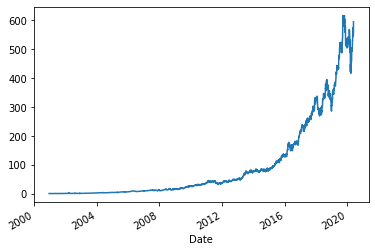

In [109]:
(returns.groupby(returns.index)['daily_return_limitsell'].mean() +1).cumprod().plot()
plt.savefig("./backtesting2020_limitsell.png", dpi=700, transparent=True)

In [72]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.groupby(returns.index)['daily_return_limitsell'].mean().mean()*252*100
stdev = returns.groupby(returns.index)['daily_return_limitsell'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 35.35%
Average yearly standard deviation: 24.82%
Sharpe Ratio: 1.404096418892119


In [73]:
#getting the weekly returns for the limit buy strategy at 8%
weekly_returns['returns_limitsell'] = returns.groupby('Trade_Identifier')['PC'].nth(-1)/returns.groupby('Trade_Identifier')['PC'].nth(0)-1
weekly_returns.loc[limit_sell_list, 'returns_limitsell'] = 0.08

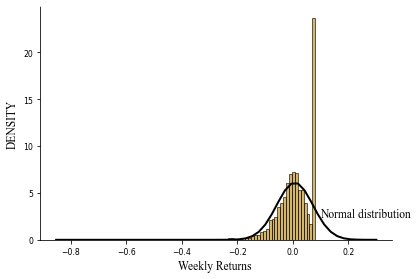

In [110]:
histogram(weekly_returns['returns_limitsell'])
plt.savefig("./backtesting2020_limitsell_hist.png", dpi=700, transparent=True)

In [75]:
weekly_returns['returns_limitsell'].describe()

count    4192.000000
mean        0.007708
std         0.065352
min        -0.800000
25%        -0.025717
50%         0.010895
75%         0.070638
max         0.249381
Name: returns_limitsell, dtype: float64

In [76]:
weekly_returns.nlargest(5,'returns_limitsell')

,Date,returns_prestige_original,returns_stoploss,returns_limitsell
Trade_Identifier,,,,
FRAN.OQ5,2014-12-09,0.249381,-0.020000,0.249381
HGGGQ.PK6,2009-02-05,0.125866,-0.020000,0.125866
FRAN.OQ8,2016-03-29,0.086755,-0.020000,0.086755
NLS.N1,2000-12-27,0.018934,-0.020000,0.080000
CTS.N1,2000-12-28,0.121622,0.121622,0.080000
